# Perform regionalization when no parameter set is available

Here we call the Regionalization WPS service to provide estimated streamflow (best estimate and ensemble) at an ungauged site using three pre-calibrated hydrological models and a large hydrometeorological database with catchment attributes (Extended CANOPEX). Multiple regionalization strategies are allowed. 

In [1]:
import datetime as dt

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from ravenpy import Emulator
from ravenpy.new_config import commands as rc
from ravenpy.new_config.emulators import GR4JCN
from ravenpy.utilities.new_config.regionalization import regionalize
from ravenpy.utilities.regionalization import read_gauged_params, read_gauged_properties

In [2]:
%%capture --no-display
ts = "ERA5_weather_data_Salmon.nc"


hru = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    hru_type="land",
)

# Set alternative names for netCDF variables
alt_names = {
    "TEMP_MIN": "tmin",
    "TEMP_MAX": "tmax",
    "PRECIP": "pr",
}

# Data types to extract from netCDF
data_type = ["TEMP_MAX", "TEMP_MIN", "PRECIP"]
data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "Latitude": hru["latitude"],
        "Longitude": hru["longitude"],
    },
}


# Model configuration
model_config = GR4JCN(
    Gauge=[
        rc.Gauge.from_nc(
            ts, data_type=data_type, alt_names=alt_names, data_kwds=data_kwds
        )
    ],
    HRUs=[hru],
    StartDate=dt.datetime(1990, 1, 1),
    EndDate=dt.datetime(2010, 12, 31),
    RunName="regionalization",
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

model_structure = "GR4JCN"

nash, params = read_gauged_params(model_structure)

variables = ["latitude", "longitude", "area", "forest"]

props = read_gauged_properties(variables)

ungauged_props = {
    "latitude": 40.4848,
    "longitude": -103.3659,
    "area": 4250.6,
    "forest": 0.4,
}

regionalization_method = "SP_IDW"

hydrograph, ensemble_hydrograph = regionalize(
    config=model_config,
    method=regionalization_method,
    nash=nash,
    params=params,
    props=props,
    target_props=ungauged_props,
    min_NSE=0.7,
    size=5,
)

The `hydrograph` and `ensemble` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [4]:
display(hydrograph)

<xarray.DataArray 'q_sim' (time: 7670, nbasins: 1)>
array([[ 28.08087713],
       [ 49.41799703],
       [643.24070341],
       ...,
       [133.07946313],
       [132.83054708],
       [132.64025259]])
Coordinates:
  * time        (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2010-12-31
    basin_name  (nbasins) object 'sub_001'
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

In [5]:
display(ensemble_hydrograph)

<xarray.Dataset>
Dimensions:     (time: 7670, nbasins: 1, members: 5, param: 6)
Coordinates:
  * time        (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2010-12-31
    basin_name  (nbasins) object 'sub_001'
  * members     (members) int64 0 1 2 3 4
  * param       (param) <U12 'GR4J_X1' 'GR4J_X2' ... 'CEMANEIGE_X2'
Dimensions without coordinates: nbasins
Data variables:
    q_sim       (members, time, nbasins) float64 28.08 14.33 ... 171.4 171.2
    parameter   (members, param) float64 282.6 -5.463 105.2 ... 1.536 0.5935
Attributes:
    title:    Regionalization ensemble
    source:   Hydrological model GR4JCN
    history:  Created by ravenpy regionalize.
    comment:  Regionalization method: SP_IDW

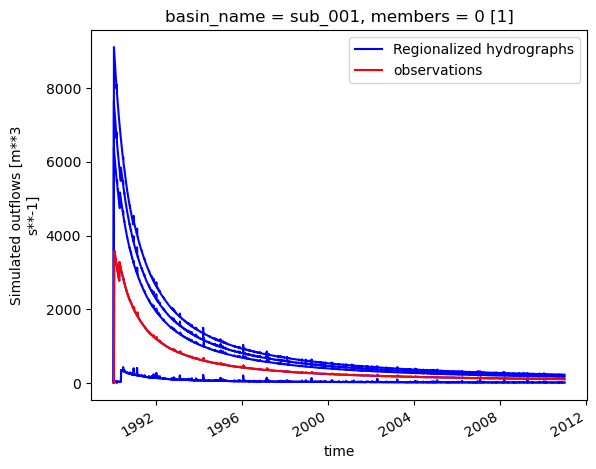

In [8]:
qq = ensemble_hydrograph.q_sim[0, :, 0]

ensemble_hydrograph.q_sim[:, :, 0].plot.line("b", x="time", add_legend=False)
ensemble_hydrograph.q_sim[1, :, 0].plot.line(
    "b", x="time", label="Regionalized hydrographs"
)
qq.plot.line("r", x="time", label="observations")
plt.legend(loc="upper right")
plt.show()

In [7]:
print("Max: ", hydrograph.max())
print("Mean: ", hydrograph.mean())
print("Monthly means: ", hydrograph.groupby("time.month").mean(dim="time"))

Max:  <xarray.DataArray 'q_sim' ()>
array(4746.92128246)
Mean:  <xarray.DataArray 'q_sim' ()>
array(596.3138143)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[680.24738309],
       [686.94799049],
       [660.74701842],
       [639.24890199],
       [624.24542525],
       [604.60424802],
       [583.77249729],
       [564.91785386],
       [548.92764452],
       [536.47047112],
       [522.34416533],
       [509.10483888]])
Coordinates:
    basin_name  (nbasins) object 'sub_001'
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows
